### Step 1: Load the MNIST dataset, load all necessary modules

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -4.41807799e-03 -5.75481961e-03 -4.08251693e-03 -4.08251693e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -4.08251693e-03 -4.70968827e-03 -8.79934640e-03 -1.15905591e-02
 -1.47589798e-02 -1.92848546e-02 -2.46717975e-02 -2.90710271e-02
 -3.05926583e-02 -3.11640127e-02 -3.19628719e-02 -3.02025355e-02
 -3.13102175e-02 -2.83833960e-02 -2.31191906e-02 -1.91666260e-02
 -1.67723008e-02 -1.09963601e-02 -8.32486080e-03 -4.38069356e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -4.08251693e-03 -5.39534598e-03
 -8.52241235e-03 -1.19850

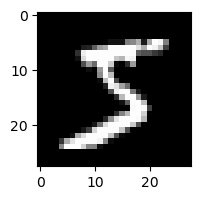

In [1]:
import os, sys
directory_path = os.path.dirname(os.path.abspath("__notebook__"))
sys.path.append('../../')
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
from models import rbm
from torchvision import datasets
from sklearn.preprocessing import StandardScaler, MinMaxScaler
train_dataset = datasets.MNIST(root='./data', train=True, download=True)
scaler = StandardScaler()
X = train_dataset.data.numpy()
n_examples = X.shape[0]
X = X.reshape(n_examples, -1)
X = scaler.fit_transform(X)
y = train_dataset.targets.numpy()
plt.figure(figsize=(2, 2))
print(X[0])
plt.imshow(scaler.inverse_transform(X[0].reshape(1, -1)).reshape(28, 28), cmap='gray')
# plt.imshow(X[0].reshape(1, -1).reshape(28, 28), cmap='gray')

### Step 2: Train the RBM (no adversary)

In [14]:
model = rbm.RBM(
    n_vis=784,
    n_hid=300
)
stats = model.fit_autograd(
    X=X[:120],
    n_gibbs=10,
    lr=0.001,
    n_epochs=60,
    batch_size=10,
    gamma=1,
    gamma_delay=20,
    rng_seed=0,
    verbose_interval=5,
    checkpoint_path=f'{directory_path}/rbm_checkpoints/rbm_mnist_demo.pth'
)

epoch: 00 of 60 | loss: -13.76 | recon_mse: 0.896 | kl_data_model: 777.724 | kl_model_data: -219.274
epoch: 05 of 60 | loss: -8.179 | recon_mse: 0.72 | kl_data_model: 755.706 | kl_model_data: -230.588
epoch: 10 of 60 | loss: -24.376 | recon_mse: 0.611 | kl_data_model: 683.266 | kl_model_data: -230.884
epoch: 15 of 60 | loss: -17.833 | recon_mse: 0.549 | kl_data_model: 724.899 | kl_model_data: -227.266
epoch: 20 of 60 | loss: -24.383 | recon_mse: 0.52 | kl_data_model: 645.808 | kl_model_data: -229.378
epoch: 25 of 60 | loss: -21.268 | recon_mse: 0.469 | kl_data_model: 668.125 | kl_model_data: -239.765
epoch: 30 of 60 | loss: -26.176 | recon_mse: 0.428 | kl_data_model: 645.038 | kl_model_data: -226.581
epoch: 35 of 60 | loss: -23.011 | recon_mse: 0.399 | kl_data_model: 637.685 | kl_model_data: -217.482
epoch: 40 of 60 | loss: -28.013 | recon_mse: 0.39 | kl_data_model: 605.418 | kl_model_data: -222.421
epoch: 45 of 60 | loss: -25.822 | recon_mse: 0.343 | kl_data_model: 595.081 | kl_model_

### Step 3: Visualize training

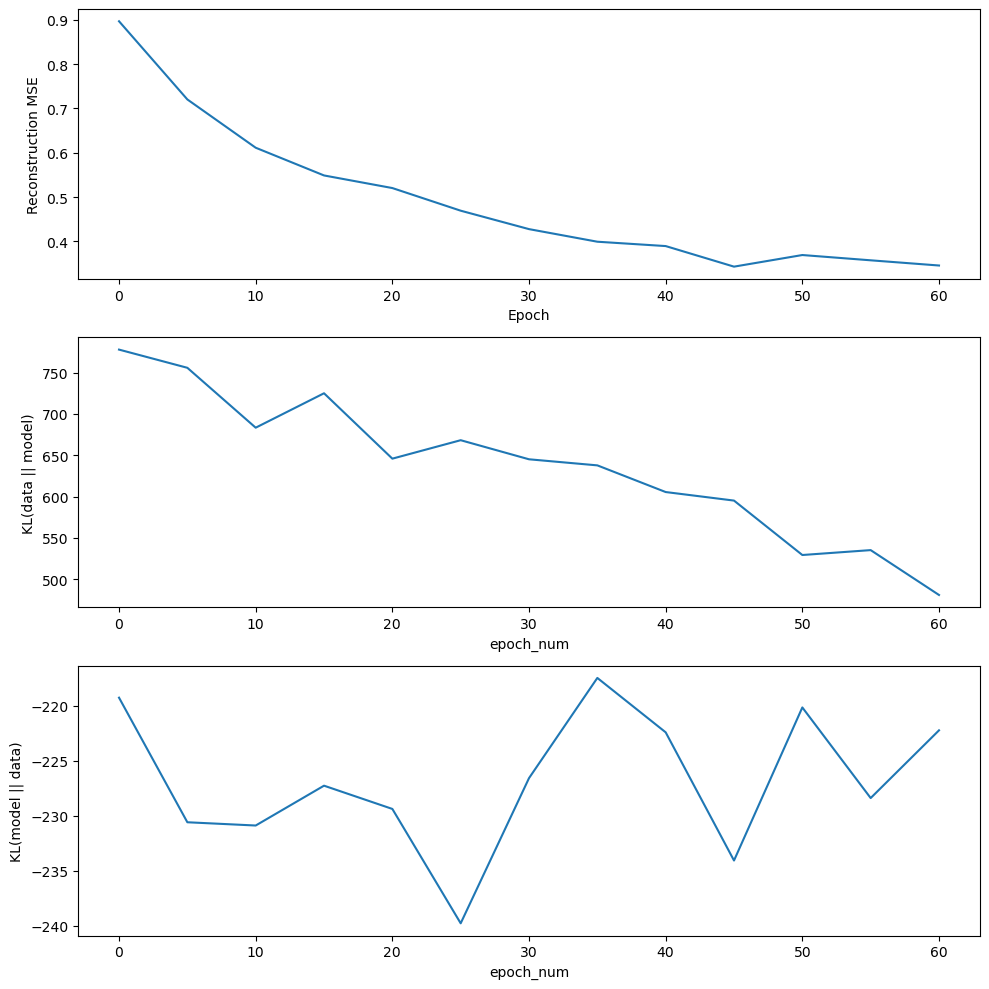

In [15]:
def visualize_learning(stats):
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))
    axs[0].plot(stats['epoch_num'], stats['recon_mse'])
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Reconstruction MSE')
    axs[1].plot(stats['epoch_num'], stats['kl_data_model'])
    axs[1].set_xlabel('epoch_num')
    axs[1].set_ylabel('KL(data || model)')
    axs[2].plot(stats['epoch_num'], stats['kl_model_data'])
    axs[2].set_xlabel('epoch_num')
    axs[2].set_ylabel('KL(model || data)')
    plt.tight_layout()
visualize_learning(stats)

### Step 4: Visualize samples

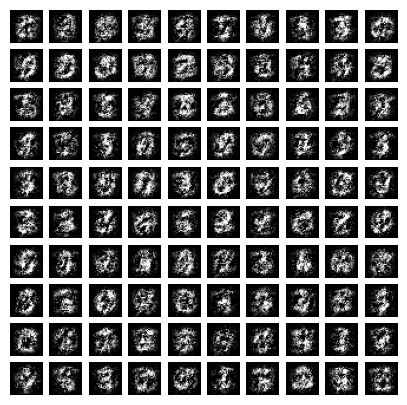

In [16]:
model = rbm.load(f'{directory_path}/rbm_checkpoints/rbm_mnist_demo.pth')
samples = model.reconstruct(np.zeros((100, 784)), n_gibbs=10)
samples = scaler.inverse_transform(samples).clip(0, 255)
fig, axes = plt.subplots(10, 10, figsize=(5, 5))
axes = axes.flatten()
for i in range(100):
    axes[i].imshow(samples[i].reshape(1, -1).reshape(28, 28) , cmap='gray')
    axes[i].axis('off')
plt.show()

### Repeat Step 2 for RBM (trained with adversary)

In [7]:
model = rbm.RBM(
    n_vis=784,
    n_hid=100
)
model.fit_autograd(
    X=X[:2000],
    n_gibbs=10,
    lr=0.001,
    n_epochs=100,
    batch_size=30,
    gamma=0.1,
    gamma_delay=50,
    rng_seed=0,
    verbose_interval=10,
    reduce_lr_on_plateau=False,
    checkpoint_path=f'{directory_path}/rbm_checkpoints/rbm_mnist_demo_adv.pth'
)

epoch: 010 of 100 | cd_loss: -11.76 | recon_mse: 1.124 | kl_data_model: 1.144 | kl_model_data: 1.614
epoch: 020 of 100 | cd_loss: -9.464 | recon_mse: 0.944 | kl_data_model: 0.005 | kl_model_data: 1.553
epoch: 030 of 100 | cd_loss: -7.812 | recon_mse: 0.898 | kl_data_model: 0.56 | kl_model_data: 0.56
epoch: 040 of 100 | cd_loss: -7.288 | recon_mse: 0.821 | kl_data_model: 0.321 | kl_model_data: 1.226
epoch: 050 of 100 | cd_loss: -0.719 | recon_mse: 0.814 | kl_data_model: 0.17 | kl_model_data: 0.759
epoch: 060 of 100 | cd_loss: 1.756 | recon_mse: 2.448 | kl_data_model: 1.284 | kl_model_data: -0.312
epoch: 070 of 100 | cd_loss: -0.631 | recon_mse: 0.763 | kl_data_model: 0.998 | kl_model_data: 0.094
epoch: 080 of 100 | cd_loss: -0.678 | recon_mse: 0.804 | kl_data_model: 0.475 | kl_model_data: 0.686
epoch: 090 of 100 | cd_loss: -0.45 | recon_mse: 0.824 | kl_data_model: 0.304 | kl_model_data: 0.722
epoch: 100 of 100 | cd_loss: 0.817 | recon_mse: 1.654 | kl_data_model: -0.01 | kl_model_data: 1

### Repeat Step 3 for RBM (trained with adversary)

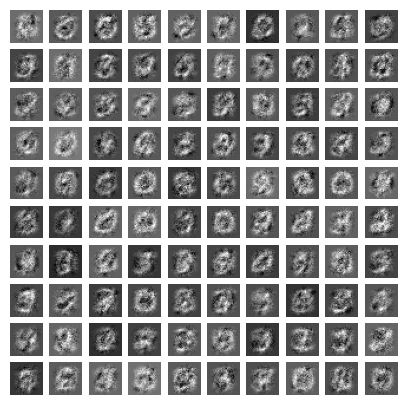

In [8]:
model = rbm.load(f'{directory_path}/rbm_checkpoints/rbm_mnist_demo_adv.pth')
samples = model.reconstruct(np.zeros((100, 784)), n_gibbs=200)
fig, axes = plt.subplots(10, 10, figsize=(5, 5))
axes = axes.flatten()
for i in range(100):
    axes[i].imshow(scaler.inverse_transform(samples[i].reshape(1, -1))\
                   .reshape(28, 28), cmap='gray')
    axes[i].axis('off')
plt.show()